# Introduction

In the previous notebook we prepared data for training our model. In this notebook we will create our model, then train the model and then evaluate it.

# Importing the data

We have already our data in the previous section in this section we will just download the data and decompress them. All the files used in this notebook are stored as publicly downloadable file.

## Downloading data.

In [ ]:
# Download clean images
!gdown https://drive.google.com/uc?id=1-CNOtMEBdZna6m5fB9WOjXyGqAcMyor9

Downloading...
From: https://drive.google.com/uc?id=1-CNOtMEBdZna6m5fB9WOjXyGqAcMyor9
To: /content/testSetPlaces205_resize.tar.gz
2.34GB [00:27, 85.7MB/s]


In [ ]:
# Download dirty images
!gdown https://drive.google.com/uc?id=1svg85MYow-kaOLk0Z_W4GS3LwShDrg2C

Downloading...
From: https://drive.google.com/uc?id=1svg85MYow-kaOLk0Z_W4GS3LwShDrg2C
To: /content/dirty_images.zip
1.51GB [00:12, 122MB/s] 


## Decompressing data.

In [ ]:
# decompressing the clean image file.
!gunzip < testSetPlaces205_resize.tar.gz | tar xvf -

# reanaming the directory.
!mv /content/testSet_resize /content/clean_images

In [ ]:
# decompressing dirty image file
!unzip dirty_images.zip

# Creating a CNN auto encoder model.

We experimented with different model architecture during the lifecycle of this project. In this notebook we use our finest performing model. This model is based on autoencoder architecture. We have also implemented skip connections to aid our model to get rid of vanishing gradient problem.



In [ ]:
# importing essential libraries.

import os
import cv2
import osgeo
import random
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import layers
from IPython.display import clear_output
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, Conv2DTranspose

## Defining model

In [ ]:
# input layer
input = layers.Input(shape=(256, 256, 3), name="input")

# convoluion layes
conv1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same',name="conv01")(input)
conv2 = layers.Conv2D(64, (3, 3), activation='relu', padding='same',name="conv02")(conv1)
conv3 = layers.Conv2D(64, (3, 3), activation='relu', padding='same',name="conv03")(conv2)

# deconvulation and skip conections
deconv1 = layers.Conv2DTranspose(64, kernel_size=3, activation='relu', padding='same',name="de-conv01")(conv3)

skip1 = layers.Add(name="skip01")([deconv1, conv2])
deconv2 = layers.Conv2DTranspose(64, kernel_size=3, activation='relu', padding='same',name="de-conv02")(skip1)

skip2 = layers.Add(name="skip02")([deconv2, conv1])
deconv3 = layers.Conv2DTranspose(64, kernel_size=3, activation='relu', padding='same',name="de-conv03")(skip2)

output = layers.Conv2D(3, kernel_size=(3, 3), padding='same',name="output")(deconv3)

## Compiling the model

In [ ]:
AE = Model(input, output)
AE.compile(optimizer='adam', loss='mse',metrics=['accuracy'])
AE.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv01 (Conv2D)                 (None, 256, 256, 64) 1792        input[0][0]                      
__________________________________________________________________________________________________
conv02 (Conv2D)                 (None, 256, 256, 64) 36928       conv01[0][0]                     
__________________________________________________________________________________________________
conv03 (Conv2D)                 (None, 256, 256, 64) 36928       conv02[0][0]                     
____________________________________________________________________________________________

# Loading images into numpy array.

Since, the model cannot take image files as direct input for training the model we need to convert image into numpy array.

We could have also used **tf.keras.preprocessing.image_dataset_from_directory** function. But this function creates y labels from directory name but in autoencoders case, the y label should also be an image. We were unable to oveeride this method so we were stuck with numpy.


We also experimented with **tf.io.read_file** to create custom data input pipeline but could not write efficient data input pipeline.

## Custom data input pipeline.

```
# https://cs230.stanford.edu/blog/datapipeline/#building-an-image-data-pipeline (Andrew Ng | Custom data pipeline.)

import os
import tensorflow as tf


# first we create 2 lists containing file names of clean and dirty images.
CLEAN_IMAGES = "/content/clean_image/clean_images"
DIRTY_IMAGES = "/content/dirty_image/dirty_images"
batch_size = 32

# read all filename into list for both clean images and dirty images
clean_images = []
for filename in os.listdir(CLEAN_IMAGES):
    clean_images.append(os.path.join(CLEAN_IMAGES,filename))

dirty_images = []
for filename in os.listdir(DIRTY_IMAGES):
    dirty_images.append(os.path.join(DIRTY_IMAGES,filename))

# We will use 20% data for validation so.
validation_size = int(0.2 * len(clean_images))

def parse_function(clean_file,dirty_file):
    cimage_string = tf.io.read_file(clean_file)
    cimage = tf.image.decode_jpeg(cimage_string, channels=3)
    #This will convert to float values in [0, 1]
    cimage = tf.image.convert_image_dtype(cimage, tf.float32)
    cimage = tf.image.resize(cimage, [256, 256])

    dimage_string = tf.io.read_file(dirty_file)
    dimage = tf.image.decode_jpeg(dimage_string, channels=3)
    #This will convert to float values in [0, 1]
    dimage = tf.image.convert_image_dtype(dimage, tf.float32)
    dimage = tf.image.resize(dimage, [256, 256])
    return cimage, dimage


dataset = tf.data.Dataset.from_tensor_slices((clean_images, dirty_images))
dataset = dataset.shuffle(len(clean_images))
dataset = dataset.map(parse_function, num_parallel_calls=10)

validation_dataset = dataset.skip(40000)
training_dataset = dataset.take(5000)

# validation_dataset = validation_dataset.batch(batch_size)
validation_dataset = validation_dataset.prefetch(1)

training_dataset = training_dataset.batch(batch_size)
training_dataset = training_dataset.prefetch(1)

```

During the experimentation phase of this project, we were only using 4000 images out of available **41,000 images** for model training. Since, only **5000 images** could be converted to numpy arrays and stored in RAM without causing any troubles.


We wrote a custom datapipeline to use all 41000 images to train the network. The pipeline was working as expected but the model was training very slow when data was given from custom data input pipeline. The **ETA** for training an **epoch** was between range of **19-22 hours** . When 5000 images were loaded as numpy arrays for training time, total time for each epoch only ranged from 2-6 minutes. So, being unable to sort the problem of data pipeline. We have discarded the pipelining process.



## Reading images as numpy arrays.

In [ ]:
# run this cell to read images into numpy arrays.

DATA_SIZE = 5000
CLEAN_IMAGES = "/content/clean_images"
DIRTY_IMAGES = "/content/dirty_images"

# array to store images
clean_images = []
dirty_images = []


count = 0;
for filename in os.listdir(CLEAN_IMAGES):
  count = count+1
  if (count <= DATA_SIZE ):
    print("Processing image " + str(count) + " out of 5000 clean images.")
    clear_output(wait=True)
    img = image.load_img(os.path.join(CLEAN_IMAGES,filename), target_size=(256, 256))
    clean_images.append(image.img_to_array(img))
  else:
    break

# Create numpy array from images data
clean_images = np.array(clean_images, dtype=np.uint16)

count = 0;
for filename in os.listdir(DIRTY_IMAGES):
  count = count+1
  if (count <= DATA_SIZE ):
    print("Processing image " + str(count) + " out of 5000 dirty images.")
    clear_output(wait=True)
    img = image.load_img(os.path.join(DIRTY_IMAGES,filename), target_size=(256, 256))
    dirty_images.append(image.img_to_array(img))
  else:
    break
# Create numpy array from images data
dirty_images = np.array(dirty_images, dtype=np.uint16)

Processing image 5000 out of 5000 dirty images.


In [ ]:
print("Shape of clean_images: ", clean_images.shape)
print("Size of clean_images: ", clean_images.nbytes)
print("Shape of dirty_images: ", dirty_images.shape)
print("Size of dirty_images: ", dirty_images.nbytes)

Shape of clean_images:  (5000, 256, 256, 3)
Size of clean_images:  1966080000
Shape of dirty_images:  (5000, 256, 256, 3)
Size of dirty_images:  1966080000


In [ ]:
# This is just a method to view images in numpy array

# https://www.kaggle.com/orion99/autoencoder-made-easy
def show_image_data(X, n=10, title=""):
    plt.figure(figsize=(15, 5))
    for i in range(n):
        ax = plt.subplot(2,n,i+1)
        plt.imshow(image.array_to_img(X[i]))
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.suptitle(title, fontsize = 20)

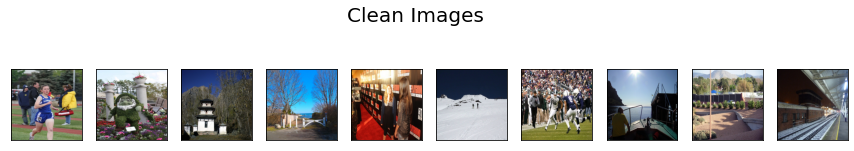

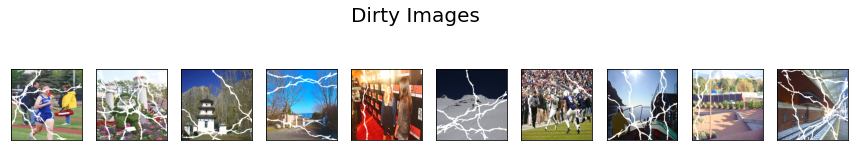

In [ ]:
show_image_data(clean_images, title="Clean Images")
show_image_data(dirty_images, title="Dirty Images")

## Splitting the numpy arrays for training and validation.

In [ ]:
train_clean_image = clean_images[:4000]
train_dirty_image = dirty_images[:4000]
val_clean_image = clean_images[4000:4500]
val_dirty_image = dirty_images[4000:4500]
test_clean_image = clean_images[4500:]
test_dirty_image = dirty_images[4500:]
print("train_clean_image", train_clean_image.shape)
print("train_dirty_image", train_dirty_image.shape)
print("val_clean_image", test_clean_image.shape)
print("val_dirty_image", test_dirty_image.shape)
print("test_clean_image", test_clean_image.shape)
print("test_dirty_image", test_dirty_image.shape)

train_clean_image (4000, 256, 256, 3)
train_dirty_image (4000, 256, 256, 3)
val_clean_image (500, 256, 256, 3)
val_dirty_image (500, 256, 256, 3)
test_clean_image (500, 256, 256, 3)
test_dirty_image (500, 256, 256, 3)


# Training the model.



In [ ]:
AE.fit(train_dirty_image, 
       train_clean_image,
       epochs=10,
       shuffle=True,
       validation_data=(val_dirty_image, val_clean_image))

Epoch 1/10
125/125 [==============================] - 90s 720ms/step - loss: 982.9083 - accuracy: 0.7600 - val_loss: 694.1815 - val_accuracy: 0.8099
Epoch 2/10
125/125 [==============================] - 89s 714ms/step - loss: 633.2324 - accuracy: 0.8161 - val_loss: 551.3028 - val_accuracy: 0.8282
Epoch 3/10
125/125 [==============================] - 89s 715ms/step - loss: 546.3344 - accuracy: 0.8157 - val_loss: 548.4503 - val_accuracy: 0.8557
Epoch 4/10
125/125 [==============================] - 89s 714ms/step - loss: 495.9718 - accuracy: 0.8228 - val_loss: 475.4028 - val_accuracy: 0.8311
Epoch 5/10
125/125 [==============================] - 89s 716ms/step - loss: 470.4049 - accuracy: 0.8187 - val_loss: 425.7928 - val_accuracy: 0.8623
Epoch 6/10
125/125 [==============================] - 90s 717ms/step - loss: 442.3981 - accuracy: 0.8269 - val_loss: 415.4255 - val_accuracy: 0.8164
Epoch 7/10
125/125 [==============================] - 89s 715ms/step - loss: 439.1349 - accuracy: 0.8269 -

# Viewing results.

In this section we will use the trained model to restore dirty image in our **test_dirty_image** array.

In [ ]:
reconstructed_images = AE.predict(test_dirty_image)

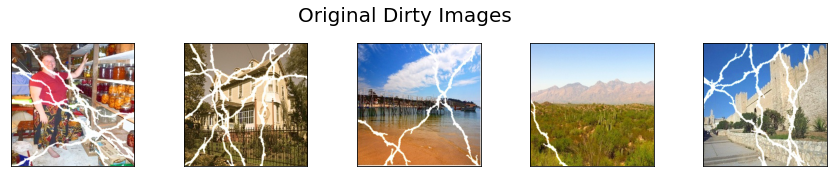

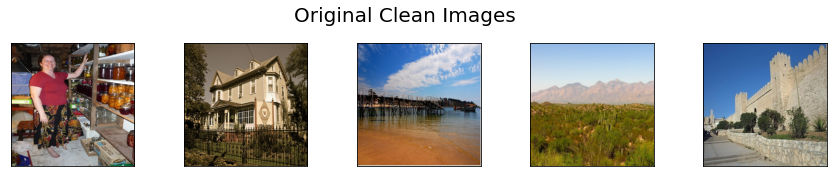

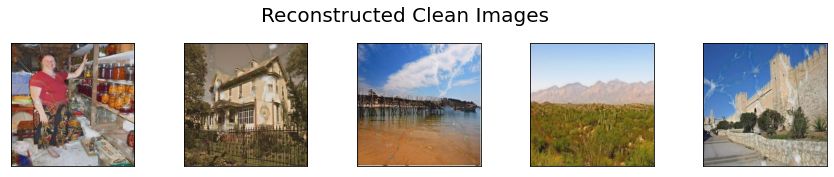

In [ ]:
show_image_data(test_dirty_image, title="Original Dirty Images",n=5)
show_image_data(test_clean_image, title="Original Clean Images",n=5)
show_image_data(reconstructed_images, title="Reconstructed Clean Images",n=5)

# Model Evaluation using PSNR metrics.

PSNR stands for Peak Signal To Noise Ratio. Higher PSNR values equate to better restoration.


In [ ]:
psnr = []

# calculating the PSNR values for each images in the test datset.
for i in range(len(reconstructed_images)):
  psnr.append(tf.image.psnr( reconstructed_images[i], test_clean_image[i], max_val=255).numpy())
  psnrs = np.array(psnr)

# printing out stats of psnr.
print("Mean PSNR: " + str(np.mean(psnrs)))
print("Median PSNR: " + str(np.median(psnrs)))
print("Maximum PSNR: " + str(np.amax(psnrs)))
print("Minimum PSNR: " + str(np.amin(psnrs)))

Mean PSNR: 6.2607913
Median PSNR: 6.022505
Maximum PSNR: 16.85398
Minimum PSNR: 1.7211113


Normal distribution of PSNR values.

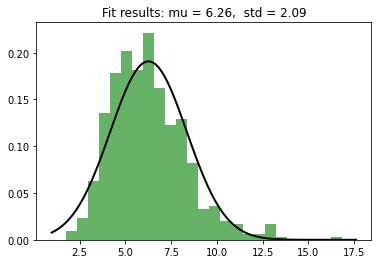

In [ ]:
# (referenced from) https://stackoverflow.com/questions/20011122/fitting-a-normal-distribution-to-1d-data
from scipy.stats import norm
import matplotlib.pyplot as plt


# Generate some data for this demonstration.
data = psnrs

# Fit a normal distribution to the data:
mu, std = norm.fit(data)

# Plot the histogram.
plt.hist(data, bins=25, density=True, alpha=0.6, color='g')

# Plot the PDF.
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, std)
plt.plot(x, p, 'k', linewidth=2)
title = "Fit results: mu = %.2f,  std = %.2f" % (mu, std)
plt.title(title)

plt.show()

**Conclusion:** SOTA papers have PSNR values of greater than 20 but we were only achive the mean PSNR of *6.26*. So, it is not that impressive result. But, on the other hand we also do not have PSNR of 0 i.e. our restored images only having noise. So, overall we can conclude that autoencoders can be definitely used for image restoration. 

# Saving and downloading model.

We have successfully trained our model to restore images. Now, we can deploy this model to create an web application that can restore images. So, we should save our model to deploy it in web application.

In [ ]:
# save model
# we will be saving our models in both formats.
AE.save('mymodel')

INFO:tensorflow:Assets written to: mymodel/assets


In [ ]:
AE.save('model.h5')

Now you can download these files from Google colab files explorer.

In [ ]:
!zip -r mymodel.zip mymodel

  adding: mymodel/ (stored 0%)
  adding: mymodel/saved_model.pb (deflated 89%)
  adding: mymodel/assets/ (stored 0%)
  adding: mymodel/variables/ (stored 0%)
  adding: mymodel/variables/variables.data-00000-of-00001 (deflated 6%)
  adding: mymodel/variables/variables.index (deflated 72%)
